In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

tf.reset_default_graph()

In [2]:
def MinMaxScaler(data):
    
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  This is separate from the ipykernel package so we can avoid doing imports until


xy shape :  (41943, 13) y shape :  (41943, 1)
train_setx shape :  (29360, 13) train_sety shape :  (29360, 1)
test_setx shape :  (12593, 13) test_sety shape :  (12593, 1)
trainX shape :  (29350, 10, 13) trainY shape :  (29350, 1)
testX shape :  (12583, 10, 13) testY shape :  (12583, 1)
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Y_pred shape :  (?, 1)
[step: 0] loss: 6.004570484161377
[step: 1] loss: 5.178064823150635
[step: 2] loss: 4.799934387207031
[step: 3] loss: 4.566197395324707
[step: 4] loss: 4.398525714874268
[step: 5] loss: 4.263012886047363
[step: 6] loss: 4.135405540466309
[step: 7] loss: 4.007088661193848
[step: 8] loss: 3.874572277069092
[step: 9] loss: 3.7521677017211914
[step: 10] loss: 3.6601641178131104
[step: 11] loss: 3.596587896347046
[step: 12] loss: 3.5533547401428223
[step: 13] 

[step: 208] loss: 2.4596428871154785
[step: 209] loss: 2.4570531845092773
[step: 210] loss: 2.4543843269348145
[step: 211] loss: 2.4518446922302246
[step: 212] loss: 2.449127674102783
[step: 213] loss: 2.4465625286102295
[step: 214] loss: 2.443917989730835
[step: 215] loss: 2.4414632320404053
[step: 216] loss: 2.438997268676758
[step: 217] loss: 2.4365828037261963
[step: 218] loss: 2.434112310409546
[step: 219] loss: 2.4316630363464355
[step: 220] loss: 2.4292938709259033
[step: 221] loss: 2.426922082901001
[step: 222] loss: 2.4246180057525635
[step: 223] loss: 2.422238826751709
[step: 224] loss: 2.4199488162994385
[step: 225] loss: 2.417630672454834
[step: 226] loss: 2.415421485900879
[step: 227] loss: 2.4131481647491455
[step: 228] loss: 2.4109442234039307
[step: 229] loss: 2.4087045192718506
[step: 230] loss: 2.406526803970337
[step: 231] loss: 2.4043772220611572
[step: 232] loss: 2.4022562503814697
[step: 233] loss: 2.4001383781433105
[step: 234] loss: 2.39802622795105
[step: 235] 

[step: 434] loss: 2.1708908081054688
[step: 435] loss: 2.1699211597442627
[step: 436] loss: 2.1689181327819824
[step: 437] loss: 2.1680657863616943
[step: 438] loss: 2.168020725250244
[step: 439] loss: 2.168231248855591
[step: 440] loss: 2.1677639484405518
[step: 441] loss: 2.167003631591797
[step: 442] loss: 2.165860652923584
[step: 443] loss: 2.1656558513641357
[step: 444] loss: 2.166231870651245
[step: 445] loss: 2.1662938594818115
[step: 446] loss: 2.1655845642089844
[step: 447] loss: 2.164027214050293
[step: 448] loss: 2.1632697582244873
[step: 449] loss: 2.163966178894043
[step: 450] loss: 2.164266586303711
[step: 451] loss: 2.1637332439422607
[step: 452] loss: 2.1619503498077393
[step: 453] loss: 2.161315679550171
[step: 454] loss: 2.1623849868774414
[step: 455] loss: 2.1625404357910156
[step: 456] loss: 2.161184310913086
[step: 457] loss: 2.1596310138702393
[step: 458] loss: 2.159785270690918
[step: 459] loss: 2.160294532775879
[step: 460] loss: 2.1591062545776367
[step: 461] l

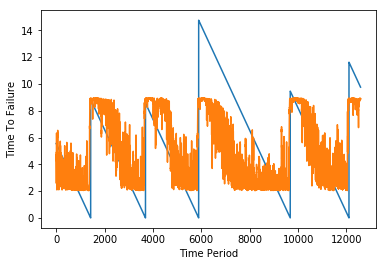

In [3]:
if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

# train Parameters
seq_length = 10
data_dim = 13
hidden_dim = 10
output_dim = 1
learning_rate = 0.005
iterations = 500

# Open, High, Low, Volume, Close
xy = np.loadtxt('preprocessed/X_train_15K.csv', delimiter=',', usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13))
y = np.loadtxt('preprocessed/y_train_15K.csv', delimiter = ',', usecols=(1))
y = np.reshape(y, (len(y),1))
#print(xy)
#print(y)
print("xy shape : ", xy.shape, "y shape : ",y.shape)

# train/test split
train_size = int(len(xy) * 0.7)
train_setx = xy[0:train_size]
train_sety = y[0:train_size]
test_setx = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence
test_sety = y[train_size - seq_length:]

# Scale each
# train_setx = MinMaxScaler(train_setx)
# train_sety = MinMaxScaler(train_sety)
# test_setx = MinMaxScaler(test_setx)
# test_sety = MinMaxScaler(test_sety)
print("train_setx shape : ", train_setx.shape, "train_sety shape : ", train_sety.shape)
print("test_setx shape : ", test_setx.shape, "test_sety shape : ", test_sety.shape)

# build datasets
def build_dataset(XX, YY, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(XX) - seq_length):
        _x = XX[i:i + seq_length, :]
        _y = YY[i+seq_length]

        #print("_x shape : ", _x.shape)
        #print("_y shape : ", _y.shape)
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_setx, train_sety, seq_length)
testX, testY = build_dataset(test_setx, test_sety, seq_length)
finalX, finalY = build_dataset(xy, y, seq_length)
# print("trainX")
# print(trainX)
# print("trainY")
# print(trainY)
# print("testX")
# print(testX)
# print("testY")
# print(testY)
print("trainX shape : ", trainX.shape, "trainY shape : ", trainY.shape)
print("testX shape : ", testX.shape, "testY shape : ", testY.shape)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output
print("Y_pred shape : ", Y_pred.shape)

# cost/loss
loss = tf.reduce_sum(tf.abs(Y_pred - Y))  # sum of the absolute values 이거 reduced_mean으로 바꿔봤는데 오차 증가함
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
rmae = tf.reduce_mean(tf.abs(targets - predictions))

sess = tf.Session() 
final_sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
final_sess.run(init)

# Training step
for i in range(iterations):
    _, step_loss = sess.run([train, loss], feed_dict={
                            X: trainX, Y: trainY})
    print("[step: {}] loss: {}".format(i, step_loss))
        
#     scores = cross_validate(reg_lin, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
#     print(scores['test_score'])
#     print("{:.4f}".format(sum(scores['test_score']) / 5))

# Test step
test_predict = sess.run(Y_pred, feed_dict={X: testX})
print("test_predict shape : ", test_predict.shape)
# rmse_val = sess.run(rmse, feed_dict={
#                 targets: testY, predictions: test_predict})
# print("RMSE: {}".format(rmse_val))

rmae_val = sess.run(rmae, feed_dict={
                targets: testY, predictions: test_predict})
print("RMAE: {}".format(rmae_val))


    
# Plot predictions
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Time To Failure")
plt.show()


In [4]:
for i in range(iterations):
    _, step_loss = final_sess.run([train, loss], feed_dict={
                            X: finalX, Y: finalY})
    print("[step: {}] loss: {}".format(i, step_loss))

[step: 0] loss: 5.194668292999268
[step: 1] loss: 5.018608093261719
[step: 2] loss: 4.825779438018799
[step: 3] loss: 4.629554271697998
[step: 4] loss: 4.441823482513428
[step: 5] loss: 4.268527507781982
[step: 6] loss: 4.107725620269775
[step: 7] loss: 3.957015037536621
[step: 8] loss: 3.821275472640991
[step: 9] loss: 3.7126171588897705
[step: 10] loss: 3.6335296630859375
[step: 11] loss: 3.5760741233825684
[step: 12] loss: 3.5255019664764404
[step: 13] loss: 3.4729673862457275
[step: 14] loss: 3.41365385055542
[step: 15] loss: 3.3476672172546387
[step: 16] loss: 3.27473783493042
[step: 17] loss: 3.19697642326355
[step: 18] loss: 3.127798080444336
[step: 19] loss: 3.104597568511963
[step: 20] loss: 3.1184189319610596
[step: 21] loss: 3.1239492893218994
[step: 22] loss: 3.1223084926605225
[step: 23] loss: 3.118065357208252
[step: 24] loss: 3.1128478050231934
[step: 25] loss: 3.1072418689727783
[step: 26] loss: 3.1014928817749023
[step: 27] loss: 3.0957255363464355
[step: 28] loss: 3.0

[step: 228] loss: 2.362337827682495
[step: 229] loss: 2.3599300384521484
[step: 230] loss: 2.3578240871429443
[step: 231] loss: 2.356865406036377
[step: 232] loss: 2.354365348815918
[step: 233] loss: 2.353508472442627
[step: 234] loss: 2.3515162467956543
[step: 235] loss: 2.3514058589935303
[step: 236] loss: 2.349463701248169
[step: 237] loss: 2.3477022647857666
[step: 238] loss: 2.3460848331451416
[step: 239] loss: 2.344414234161377
[step: 240] loss: 2.342906951904297
[step: 241] loss: 2.3416013717651367
[step: 242] loss: 2.3397626876831055
[step: 243] loss: 2.338709592819214
[step: 244] loss: 2.3370778560638428
[step: 245] loss: 2.3357231616973877
[step: 246] loss: 2.3343777656555176
[step: 247] loss: 2.3328726291656494
[step: 248] loss: 2.3316290378570557
[step: 249] loss: 2.3299922943115234
[step: 250] loss: 2.328900098800659
[step: 251] loss: 2.3274154663085938
[step: 252] loss: 2.3263003826141357
[step: 253] loss: 2.324916124343872
[step: 254] loss: 2.3237595558166504
[step: 255]

[step: 453] loss: 2.189129590988159
[step: 454] loss: 2.1880369186401367
[step: 455] loss: 2.1895318031311035
[step: 456] loss: 2.189283847808838
[step: 457] loss: 2.1901369094848633
[step: 458] loss: 2.187340021133423
[step: 459] loss: 2.1870651245117188
[step: 460] loss: 2.186671495437622
[step: 461] loss: 2.1867425441741943
[step: 462] loss: 2.1855525970458984
[step: 463] loss: 2.185385227203369
[step: 464] loss: 2.184576988220215
[step: 465] loss: 2.18448805809021
[step: 466] loss: 2.1835641860961914
[step: 467] loss: 2.1841177940368652
[step: 468] loss: 2.1835196018218994
[step: 469] loss: 2.1838037967681885
[step: 470] loss: 2.183342456817627
[step: 471] loss: 2.184002161026001
[step: 472] loss: 2.1825547218322754
[step: 473] loss: 2.1819710731506348
[step: 474] loss: 2.1809253692626953
[step: 475] loss: 2.1801741123199463
[step: 476] loss: 2.1799817085266113
[step: 477] loss: 2.180187702178955
[step: 478] loss: 2.1804518699645996
[step: 479] loss: 2.180575370788574
[step: 480] l

In [5]:
#s_t = time.time()

test_path = 'test'
test_list = os.listdir(test_path)
X_test = []
number_of_csvs = 2624
number_of_rows_in_each_csvs = 150000
divide_size = int(number_of_rows_in_each_csvs/seq_length)
print("divide_size : ", divide_size)


for path in test_list:
    test = pd.read_csv(os.path.join(test_path, path), dtype=np.float64)
    #print("test shape : ", test.shape)
    for i in range(0, seq_length):
        #test_divided_by_size = test[i*size:(i+1)*15000, :]
        test_divided_by_length = test[i*divide_size:(i+1)*divide_size]
        #print("test_divided_by_length shape : ", test_divided_by_length.shape)

        X_test.append(gen_features(test_divided_by_length).values)
    
X_test = np.array(X_test)
print("X_test shape : ", X_test.shape) #maybe 2624*10 = 26240 (26240,13)
#print(X_test[0:1000, :])

def build_dataset_for_predict(XX, seq_length):
    dataX = []
    for i in range(0, number_of_csvs*seq_length,seq_length): # 0 ~ 26230
        _x = XX[i:i + seq_length, :]
        dataX.append(_x)
    return np.array(dataX)

X_test_final = build_dataset_for_predict(X_test, seq_length)
print("X_test_final shape : ", X_test_final.shape) # (26240, 10, 13)

#X_test = MinMaxScaler(X_test)
#scaler = StandardScaler().fit(X_test)
#X_test = scaler.transform(X_test)

predict = final_sess.run(Y_pred, feed_dict={X: X_test_final})
print("predict shape : ", predict.shape)

# reg = reg_grid.best_estimator_
# reg.fit(X_train, y_train)
# y_pred = reg.predict(X_test)
pd.DataFrame(predict).to_csv('20190322_prediction_LSTM_reduced_mean_0.005_final_sess.csv', header=None)

#e_t = time.time()
#duration = (e_t - s_t) / 60
#print("{:.1f} min tooked".format(duration))

divide_size :  15000
X_test shape :  (26240, 13)
X_test_final shape :  (2624, 10, 13)
predict shape :  (2624, 1)
